# 0. 데이터 불러오기


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test1_all = pd.read_csv("../../data/test1_all.csv")


print(test1_all.shape)
print(test1_all.columns)

(30671, 88)
Index(['BD1', 'BD1_11', 'BD2', 'BD2_1', 'BD2_31', 'BD7_4', 'BD7_5', 'BE3_31',
       'BE3_72', 'BE3_76', 'BE3_82', 'BE3_86', 'BE3_92', 'BE5_1', 'BO1',
       'BO1_1', 'BO1_2', 'BO1_3', 'BO2_1', 'BP1', 'BP6_10', 'BP6_2', 'BP6_31',
       'BP7', 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5',
       'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8', 'BP_PHQ_9', 'BS12_1', 'BS12_2',
       'BS13', 'BS1_1', 'BS3_1', 'BS3_2', 'BS6_3', 'BS8_2', 'BS9_2', 'D_1_1',
       'D_2_1', 'D_2_wk', 'EC1_1', 'EC_lgw_2', 'EC_lgw_4', 'EC_lgw_5',
       'EC_occp', 'EC_stt_1', 'EC_wht_0', 'EC_wht_23', 'LQ1_mn', 'LQ1_sb',
       'LQ2_ab', 'LQ2_mn', 'LQ4_00', 'LQ4_15', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL',
       'LQ_4EQL', 'LQ_5EQL', 'age', 'allownc', 'apt_t', 'educ', 'fam_rela',
       'genertn', 'ho_incm', 'house', 'incm', 'live_t', 'marri_1', 'marri_2',
       'occp', 'region', 'sex', 'town_t', 'BE3_walk', 'BE3_work_hard',
       'BE3_work_medium', 'BE3_move', 'BE3_leisure_hard', 'BE3_leisure_medium',


---
# 8. 회귀 모델
1. XGBoostRegressor
# 분류 모델
1. RF 
2. Logistic 
3. SVM 
- y 값 : 
    - `PHQ_score` : 우울지수 (max : 27, min : 0) 
    - max : 100, min : 0(100점 만점)으로 스케일링해서 우울지수를 예측하는 회귀모델 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 만점 (27 ~ 0) => (100 ~ 0)
y = test1_all["PHQ_score"]
X = test1_all.drop("PHQ_score", axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.75, random_state=2025, stratify = y)

print(X_train.shape, X_valid.shape)


(23003, 87) (7668, 87)


In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.2,
    gamma=0.1,
    objective='reg:squarederror'
)

xgb_model.fit(X_train_scaled, y_train)

pred_xgb = xgb_model.predict(X_valid_scaled)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_valid, pred_xgb)))
print("XGBoost R2:", r2_score(y_valid, pred_xgb))


XGBoost RMSE: 0.41864018545706383
XGBoost R2: 0.9989871190124245


In [11]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.2)
elastic_model.fit(X_train_scaled, y_train)

pred_elastic = elastic_model.predict(X_valid_scaled)

print("ElasticNet RMSE:", np.sqrt(mean_squared_error(y_valid, pred_elastic)))
print("ElasticNet R2:", r2_score(y_valid, pred_elastic))

# 가중치 해석
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": elastic_model.coef_
}).sort_values("coef", ascending=False)

print(coef_df.head(20))


ElasticNet RMSE: 0.38778277475541784
ElasticNet R2: 0.9991309322807366
     feature      coef
26  BP_PHQ_3  3.115025
27  BP_PHQ_4  3.094265
24  BP_PHQ_1  2.504174
28  BP_PHQ_5  2.307607
25  BP_PHQ_2  2.164724
29  BP_PHQ_6  1.876635
30  BP_PHQ_7  1.618317
32  BP_PHQ_9  1.382436
31  BP_PHQ_8  1.300108
63   LQ_5EQL  0.110222
42     D_1_1  0.057867
50  EC_stt_1  0.027204
62   LQ_4EQL  0.023581
45     EC1_1  0.016501
44    D_2_wk  0.014901
15     BO1_1  0.013896
78       sex  0.013819
75   marri_2  0.008301
53    LQ1_mn  0.006413
3      BD2_1  0.004421


In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

pred_rf = rf_model.predict(X_valid_scaled)

print("RF RMSE:", np.sqrt(mean_squared_error(y_valid, pred_rf)))
print("RF R2:", r2_score(y_valid, pred_rf))

# 변수 중요도
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(20))


RF RMSE: 2.507319804349856
RF R2: 0.9636674355182392
BP_PHQ_4    0.144466
BP_PHQ_2    0.135099
BP_PHQ_3    0.121357
BP_PHQ_1    0.108867
BP_PHQ_5    0.093019
BP_PHQ_6    0.085314
BP_PHQ_9    0.054715
BP_PHQ_7    0.051604
BP_PHQ_8    0.040093
LQ_5EQL     0.021987
BP1         0.018439
D_1_1       0.013627
LQ1_mn      0.005718
LQ4_15      0.005620
LQ4_00      0.005450
LQ_4EQL     0.005324
LQ_3EQL     0.004437
D_2_wk      0.004095
age         0.003576
LQ1_sb      0.003342
dtype: float64


In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Train 성능 계산
pred_train_xgb = xgb_model.predict(X_train_scaled)
pred_train_rf = rf_model.predict(X_train_scaled)
pred_train_elastic = elastic_model.predict(X_train_scaled)

print("=== Train vs Valid 성능 비교 ===")
print("XGB  Train R2:", r2_score(y_train, pred_train_xgb))
print("XGB  Valid R2:", r2_score(y_valid, pred_xgb))
print("RF   Train R2:", r2_score(y_train, pred_train_rf))
print("RF   Valid R2:", r2_score(y_valid, pred_rf))
print("Elastic Train R2:", r2_score(y_train, pred_train_elastic))
print("Elastic Valid R2:", r2_score(y_valid, pred_elastic))


=== Train vs Valid 성능 비교 ===
XGB  Train R2: 0.9995706119049973
XGB  Valid R2: 0.9989871190124245
RF   Train R2: 0.9815257410317457
RF   Valid R2: 0.9636674355182392
Elastic Train R2: 0.9991452333831526
Elastic Valid R2: 0.9991309322807366


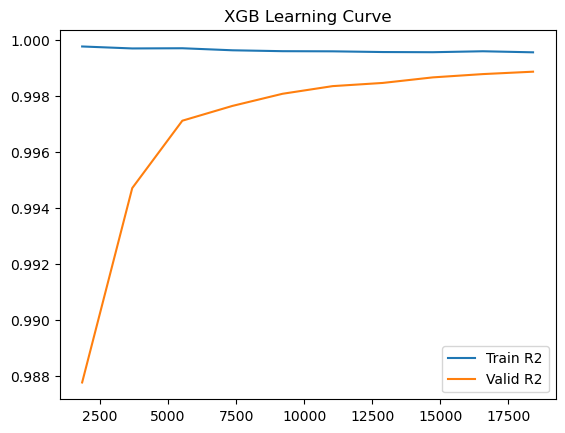

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train R2")
plt.plot(train_sizes, valid_scores.mean(axis=1), label="Valid R2")
plt.legend()
plt.title("XGB Learning Curve")
plt.show()


In [21]:
from xgboost import XGBRegressor

xgb_model_es = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=1700,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.2,
    gamma=0.1,
    objective='reg:squarederror',
    # ⬇⬇⬇ 요 둘을 여기로 옮겨야 함
    eval_metric='rmse',
    early_stopping_rounds=50
)

xgb_model_es.fit(
    X_train_scaled, y_train,
    eval_set=[(X_valid_scaled, y_valid)],
    verbose=True
)

print("Best iteration:", xgb_model_es.best_iteration)
print("Best score:", xgb_model_es.best_score)



[0]	validation_0-rmse:12.62774
[1]	validation_0-rmse:12.11432
[2]	validation_0-rmse:11.64596
[3]	validation_0-rmse:11.18590
[4]	validation_0-rmse:10.74733
[5]	validation_0-rmse:10.33022
[6]	validation_0-rmse:9.92636
[7]	validation_0-rmse:9.54597
[8]	validation_0-rmse:9.17909
[9]	validation_0-rmse:8.83723
[10]	validation_0-rmse:8.51067
[11]	validation_0-rmse:8.18776
[12]	validation_0-rmse:7.87686
[13]	validation_0-rmse:7.59280
[14]	validation_0-rmse:7.31426
[15]	validation_0-rmse:7.05370
[16]	validation_0-rmse:6.80425
[17]	validation_0-rmse:6.55554
[18]	validation_0-rmse:6.31610
[19]	validation_0-rmse:6.08093
[20]	validation_0-rmse:5.87846
[21]	validation_0-rmse:5.66759
[22]	validation_0-rmse:5.46570
[23]	validation_0-rmse:5.27543
[24]	validation_0-rmse:5.08418
[25]	validation_0-rmse:4.90636
[26]	validation_0-rmse:4.73153
[27]	validation_0-rmse:4.57683
[28]	validation_0-rmse:4.41817
[29]	validation_0-rmse:4.26261
[30]	validation_0-rmse:4.12304
[31]	validation_0-rmse:3.97939
[32]	validat